In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
from matplotlib import cm
from matplotlib import colors as c
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

Adaptive Evaluation Step = 1000


In [4]:
specs,meta = Data.Spectra(sim='lgal',noise = 'none', lib = 'bc03', sample = 'mini_mocha')
photo, _ = Data.Photometry(sim='lgal', noise= 'none', lib='bc03', sample='mini_mocha') 
input_mass = meta['logM_total'][:10]

In [5]:
class convergence_plotter():
    def __init__(self,walkers,num_run,data_dir):
        self.num_walkers = walkers
        self.num_run = num_run
        self.data_dir = data_dir
        self.files = []
        
    def post(self):
        data = [x for x in self.files]
        
        return data
        
    def opener(self):
        f = [x for x in glob.glob(f'{self.data_dir}/*.hdf5')]  
        f.sort()
        print(f)
        files = []
        
        for i in f:
            file = h5py.File(i,'r')
            files.append(file)
        
        self.files = files
        return None
    def walker_perc_plot(self,spec_photo,step=1000, flag = ""):
        import seaborn as sns
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)
        
        for sample,idx in zip(data,range(num_gal)):
            plt.figure(figsize=(12,9))
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Median')
            plt.grid()
            plt.title(f'{spec_photo} galaxy {idx + 1} walker-percentile plot{flag}')
            plt.axhline(input_mass[idx], lw = 1, c = 'r')
            plt.text(1000,input_mass[idx],f'{input_mass[idx]}')
            #plt.xlim(-10000,None)
            
            colors = plt.cm.copper(np.linspace(0,1,self.num_walkers))            
            for i in range(self.num_walkers):
                y,up_perc,lo_perc = [], [], []
                length = len(sample)//self.num_walkers
                inc = length//step
                x_axis = (np.arange(inc)+1)*step
                for n in range(inc):
                    walker_sample = sample[i:step * (1+n):self.num_walkers]
                    up = np.percentile(walker_sample,84.1)
                    lo = np.percentile(walker_sample,15.9)
                    med = np.median(walker_sample)
                    up_perc.append(up-med)
                    lo_perc.append(med-lo)
                    y.append(med)
                    
                yerr = np.vstack((up_perc,lo_perc))
                plt.plot(x_axis,y,label= f'walker {i+1}',lw = 0.5,c = 'grey')#colors[i])
                plt.fill_between(x_axis, np.array(y)-np.array(lo_perc), np.array(y)+np.array(up_perc),color='gray', alpha=0.05)
                
            plt.savefig(f'Walker-Percentile plot galaxy {idx+1}{flag}.pdf', format = 'pdf')
            plt.show()
    
    def avg_perc_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)
        
        for sample,idx in zip(data,range(num_gal)):
            y,up_perc,lo_perc = [], [], []
            length = len(sample)
            inc = length//step
            x_axis = (np.arange(inc)+1)*step
            for n in range(inc):
                up = np.percentile(sample[:step*(1+n)],84.1)
                lo = np.percentile(sample[:step*(1+n)],15.9)
                med = np.median(sample[:step*(1+n)])
                up_perc.append(up-med)
                lo_perc.append(med-lo)
                y.append(med)
            
            yerr = np.vstack((up_perc,lo_perc))    
            plt.figure(figsize=(12,9))
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Median')
            plt.grid()
            plt.title(f'{spec_photo} galaxy {idx+1} percentile plot')
            plt.axhline(input_mass[idx], lw = 1, c = 'r')
            plt.text(1000,input_mass[idx],f'{input_mass[idx]}')
            plt.text(length,y[-1],f'{y[-1]}')
            plt.errorbar(x_axis,y,yerr=yerr,fmt = '.k', ecolor = 'gray', elinewidth=1,capsize=1)
            plt.xlim(-10000,None)
            plt.savefig(f'Percentile plot galaxy {idx+1}.pdf', format = 'pdf')
            plt.show()
    def hist_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal=len(data)
            
        for sample,idx in zip(data,range(num_gal)):
            length = len(sample)
            inc = length//step
            colors = plt.cm.copper_r(np.linspace(0,1,inc))
            plt.figure(figsize=(12,9))
            for n in range(inc):
                hist = plt.hist(sample[:(1+n)*step],bins=50,histtype='step',color=colors[n],density='True',linewidth=1.2)

            plt.xlabel('$log M*$')
            plt.ylabel('Frequency')
            plt.title(f'{spec_photo } galaxy {idx+1} histogram')
            norm = c.Normalize(vmin=1,vmax=length) #Upper and lower boundaries for the color bar
            cbar = plt.colorbar(cm.ScalarMappable(norm = norm, cmap=cm.copper_r))
            plt.show()
                      
        return None
    
    def GRD2(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = []
        for idx in range(self.num_walkers):
            r_sample.append(sample[idx::self.num_walkers])
        means = []
        sq_means = []
        
        for m in r_sample:

            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))
            
        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W

        return PSRF
    
        
    def GRD(self,sample):
        M = self.num_walkers
        N = len(sample)//M
        r_sample = np.reshape(sample,(M,N))
        means = [] #For E(X)
        sq_means = [] #For E(X^2)

        for m in r_sample:
            means.append(np.mean(m))
            sq_means.append(np.mean(m**2))

        tot_mean = np.mean(means)
        B = N*np.sum((means-tot_mean)**2)/(M-1)
        W = np.sum(sq_means-np.square(means))/M
        p_var = W*(N-1)/N+(M+1)*B/(M*N)
        PSRF = p_var/W


        return PSRF

    def PSRF_plot(self,spec_photo,step=1000):
        data = [x['mcmc_chain'][...][:,0] for x in self.files]
        num_gal = len(data)

        for sample,idx in zip(data,range(num_gal)):
            PSRFs = []
            length = len(sample)
            inc = length//step
            x_axis = np.arange(inc)*step
            plt.figure(figsize=(12,9))
            for n in range(inc):
                PSRFs.append(self.GRD2(sample[:(1+n)*step]))
            
            plt.plot(x_axis,PSRFs, c = 'k', lw = 2)
            plt.axhline(1.1, c = 'r', ls = '--', lw = 1)
            plt.ylim(0,None)
            plt.xlim(0,None)
            plt.grid()
            plt.xlabel('$N_{iteration}$')
            plt.ylabel('Potential Scale Reduction Factor (PSRF)')
            plt.title(f'{spec_photo} galaxy {idx+1} PSRF plot')
            plt.savefig(f'{spec_photo} galaxy {idx+1} PSRF plot.pdf', format = 'pdf')
            plt.show()
            
BFGS = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/')
CG = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/')
L_BFGS_B = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/L-BFGS-B/')
Nelder_Mead = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/')
Powell = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/')
SLSQP = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/SLSQP/')
Nelder_Mead.opener()
SLSQP.opener()
CG.opener()
L_BFGS_B.opener()
Powell.opener()
BFGS.opener()

['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/Nelder-Mead.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/SLSQP/SLSQP.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/L-BFGS-B/L-BFGS-B.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS.hdf5']


In [302]:
gal1_mass = input_mass[0]
walker = np.arange(20)+1
def get_init_pos(method,name):
    data = method.post()
    init_pos = data[0]['mcmc_chain'][...][:,0]
    return {name : init_pos}

def plot_resid2(data_list):
    method = []
    mean = []
    for elem in data_list:
        method.append(list(elem.keys())[0])
        mean.append(np.mean(np.abs(list(elem.values())[0]-gal1_mass)))
    x = np.arange(len(method))  # the label locations
    width = 0.40  # the width of the bars
    fig, ax = plt.subplots(figsize=(8,5))
    rects = ax.bar(x, mean, width, color = 'lightblue')
    ax.set_ylabel('Difference')
    ax.set_title('Difference between initial positions and the truth')
    ax.set_xticks(x)
    ax.set_xticklabels(method)

def plot_resid2_gal(data_list):
    method = []
    mean = []
    
    for i,elem in enumerate(data_list):
        method.append(list(elem.keys())[0])
        mean.append(np.mean(np.abs(list(elem.values())[0]-input_mass[i])))
    x = np.arange(len(method))  # the label locations
    width = 0.40  # the width of the bars
    fig, ax = plt.subplots(figsize=(8,5))
    rects = ax.bar(x, mean, width, color = 'lightblue')
    ax.set_ylabel('Difference')
    ax.set_title('Difference between initial positions and the truth')
    ax.set_xticks(x)
    ax.set_xticklabels(method)
    

def plot_resid(data):
    fig, axs = plt.subplots(2, 1, sharex=True,figsize=(10,10),gridspec_kw={'height_ratios': [3, 1]})
    method = list(data.keys())[0]
    pos = list(data.values())[0]
    axs[0].set_title(method)
    axs[0].scatter(walker, pos, label = f'{method}')
    axs[0].set_xticks(np.arange(1,21,1))
    axs[0].set_ylabel('$Log M^*$')
    axs[0].hlines(gal1_mass,xmin=0,xmax=21, color = 'r', linewidth = 1)
    axs[1].plot(walker, np.abs(pos-gal1_mass), label = f'{method}')
    axs[1].set_ylabel('Absolute Residual')
    axs[1].set_xlabel('Walkers')
    fig.subplots_adjust(hspace=0)
    plt.xlim(0,21)
    plt.show()
    
BFGS_pos = get_init_pos(BFGS,'BFGS')
CG_pos = get_init_pos(CG,'CG')
L_BFGS_B_pos = get_init_pos(L_BFGS_B,'L-BFGS-B')
Nelder_Mead_pos = get_init_pos(Nelder_Mead,'Nelder-Mead')
Powell_pos = get_init_pos(Powell,'Powell')
SLSQP_pos = get_init_pos(SLSQP,'SLSQP')
methods_list = [BFGS_pos,CG_pos,L_BFGS_B_pos,Nelder_Mead_pos,Powell_pos,SLSQP_pos]

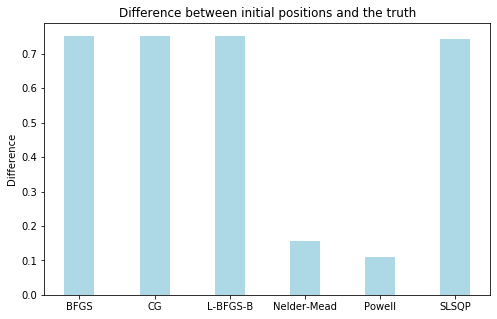

In [7]:
plot_resid2(methods_list)
plt.savefig('Difference2.pdf', format = 'pdf')

In [8]:
T = {}
IT = {}

In [76]:
T['Powell'] = 229.89574871399998
IT['Powell'] = 10
T['Nelder-Mead'] = 63.216607831
IT['Nelder-Mead'] = 100
T['BFGS'] = 63.392910795999995
IT['BFGS'] = 0
T['CG'] = 60.632645095
IT['CG'] = 0
T['L-BFGS-B'] = 54.060697207
IT['L-BFGS-B'] = 1
T['SLSQP'] = 61.779593461999994
IT['SLSQP'] = 16


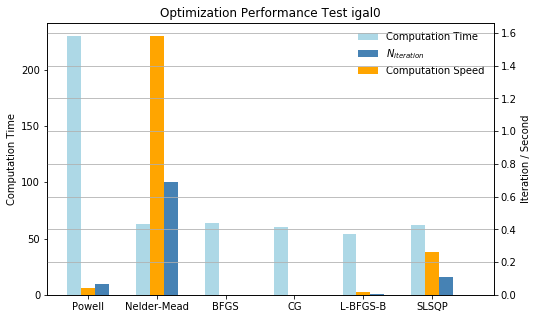

In [82]:
methods = []
times = []
its = []
v = []
for item,item2 in zip(T.items(),IT.items()):
    method, time = item
    methods.append(method)
    times.append(time)
    method, it = item2
    its.append(it)
    v.append(it/time)
    
x = np.arange(len(methods))  # the label locations
width = 0.20  # the width of the bars
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()

plt.title('Optimization Performance Test igal0')
rects = ax.bar(x-width, times, width, color = 'lightblue', label = 'Computation Time')
rects2 = ax.bar(x+width, its, width, color = 'steelblue', label = '$N_{iteration}$')
rects4 = ax.bar(x+width, np.zeros(6), color = 'orange', label = 'Computation Speed')
rects3 = ax2.bar(x, v , width, color = 'orange', label = 'Computation Speed')
ax.set_ylabel('Computation Time')

# ax2.plot(x,v, c = 'darkblue')
# ax.set_title('Difference between initial positions and the truth')
ax.set_xticks(x)
ax2.set_ylim(0,None)
ax.set_xticklabels(methods)
ax2.set_ylabel('Iteration / Second')
# ax.set_yscale('log')
ax.legend(frameon = False)
plt.grid()
plt.savefig('performance_test.pdf', format = 'pdf')
plt.show()

In [224]:
Powell0 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell0')
Powell1 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell1')
Powell2 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell2')
Powell3 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell3')
Powell4 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell4')
Powell5 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell5')
Powell6 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell6')
Powell7 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell7')
Powell8 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell8')
Powell9 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell9')

Powell0.opener()
Powell1.opener()
Powell2.opener()
Powell3.opener()
Powell4.opener()
Powell5.opener()
Powell6.opener()
Powell7.opener()
Powell8.opener()
Powell9.opener()

NM0 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/NM0')
NM1 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/NM1')
NM2 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/NM2')
NM3 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/NM3')
NM4 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/NM4')
NM5 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/NM5')
NM6 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/NM6')
NM7 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/NM7')
NM8 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/NM8')
NM9 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Nelder-Mead/NM9')

NM0.opener()
NM1.opener()
NM2.opener()
NM3.opener()
NM4.opener()
NM5.opener()
NM6.opener()
NM7.opener()
NM8.opener()
NM9.opener()

BFGS0 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS0')
BFGS1 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS1')
BFGS2 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS2')
BFGS3 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS3')
BFGS4 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS4')
BFGS5 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS5')
BFGS6 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS6')
BFGS7 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS7')
BFGS8 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS8')
BFGS9 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/BFGS/BFGS9')

BFGS0.opener()
BFGS1.opener()
BFGS2.opener()
BFGS3.opener()
BFGS4.opener()
BFGS5.opener()
BFGS6.opener()
BFGS7.opener()
BFGS8.opener()
BFGS9.opener()

CG0 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG0')
CG1 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG1')
CG2 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG2')
CG3 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG3')
CG4 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG4')
CG5 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG5')
CG6 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG6')
CG7 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG7')
CG8 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG8')
CG9 = convergence_plotter(20,1000,'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/CG/CG9')

CG0.opener()
CG1.opener()
CG2.opener()
CG3.opener()
CG4.opener()
CG5.opener()
CG6.opener()
CG7.opener()
CG8.opener()
CG9.opener()

['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell0/Powell0.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell1/Powell1.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell2/Powell2.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell3/Powell3.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell4/Powell4.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell5/Powell5.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell6/Powell6.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minimization_test2/Powell/Powell7/Powell7.hdf5']
['/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ifsps/minim

In [227]:
NM0_pos = get_init_pos(NM0,'NM0')
Powell0_pos = get_init_pos(Powell0,'Pow0')
CG0_pos = get_init_pos(CG0,'CG0')
BFGS0_pos = get_init_pos(BFGS0,'BFGS0')

NM1_pos = get_init_pos(NM1,'NM1')
Powell1_pos = get_init_pos(Powell1,'Pow1')
CG1_pos = get_init_pos(CG1,'CG1')
BFGS1_pos = get_init_pos(BFGS1,'BFGS1')

NM2_pos = get_init_pos(NM2,'NM2')
Powell2_pos = get_init_pos(Powell2,'Pow2')
CG2_pos = get_init_pos(CG2,'CG2')
BFGS2_pos = get_init_pos(BFGS2,'BFGS2')

NM3_pos = get_init_pos(NM3,'NM3')
Powell3_pos = get_init_pos(Powell3,'Pow3')
CG3_pos = get_init_pos(CG3,'CG3')
BFGS3_pos = get_init_pos(BFGS3,'BFGS3')

NM4_pos = get_init_pos(NM4,'NM4')
Powell4_pos = get_init_pos(Powell4,'Pow4')
CG4_pos = get_init_pos(CG4,'CG4')
BFGS4_pos = get_init_pos(BFGS4,'BFGS4')

NM5_pos = get_init_pos(NM5,'NM5')
Powell5_pos = get_init_pos(Powell5,'Pow5')
CG5_pos = get_init_pos(CG5,'CG5')
BFGS5_pos = get_init_pos(BFGS5,'BFGS5')

NM6_pos = get_init_pos(NM6,'NM6')
Powell6_pos = get_init_pos(Powell6,'Pow6')
CG6_pos = get_init_pos(CG6,'CG6')
BFGS6_pos = get_init_pos(BFGS6,'BFGS6')

NM7_pos = get_init_pos(NM7,'NM7')
Powell7_pos = get_init_pos(Powell7,'Pow7')
CG7_pos = get_init_pos(CG7,'CG7')
BFGS7_pos = get_init_pos(BFGS7,'BFGS7')

NM8_pos = get_init_pos(NM8,'NM8')
Powell8_pos = get_init_pos(Powell8,'Pow8')
CG8_pos = get_init_pos(CG8,'CG8')
BFGS8_pos = get_init_pos(BFGS8,'BFGS8')

NM9_pos = get_init_pos(NM9,'NM9')
Powell9_pos = get_init_pos(Powell9,'Pow9')
CG9_pos = get_init_pos(CG9,'CG9')
BFGS9_pos = get_init_pos(BFGS9,'BFGS9')

NM_list = [NM0_pos,NM1_pos,NM2_pos,NM3_pos,NM4_pos,NM5_pos,NM6_pos,NM7_pos,NM8_pos,NM9_pos]
Po_list = [Powell0_pos,Powell1_pos,Powell2_pos,Powell3_pos,Powell4_pos,Powell5_pos,Powell6_pos,Powell7_pos,Powell8_pos,Powell9_pos]
CG_list = [CG0_pos,CG1_pos,CG2_pos,CG3_pos,CG4_pos,CG5_pos,CG6_pos,CG7_pos,CG8_pos,CG9_pos]
BFGS_list = [BFGS0_pos,BFGS1_pos,BFGS2_pos,BFGS3_pos,BFGS4_pos,BFGS5_pos,BFGS6_pos,BFGS7_pos,BFGS8_pos,BFGS9_pos]


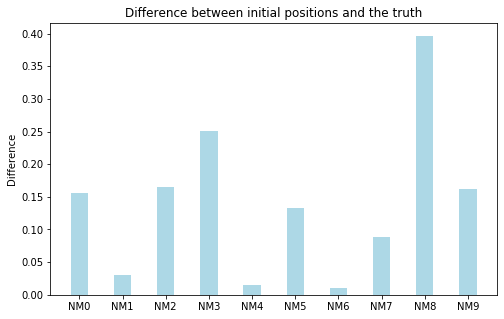

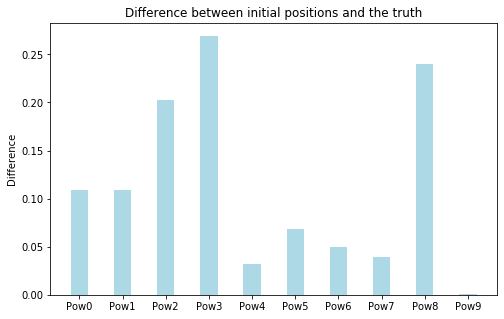

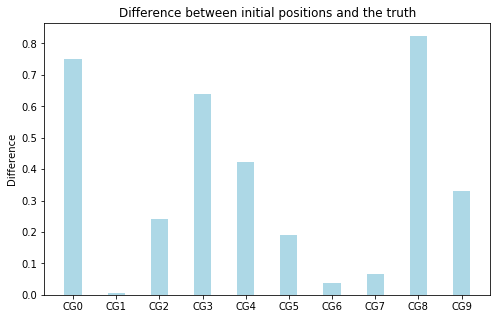

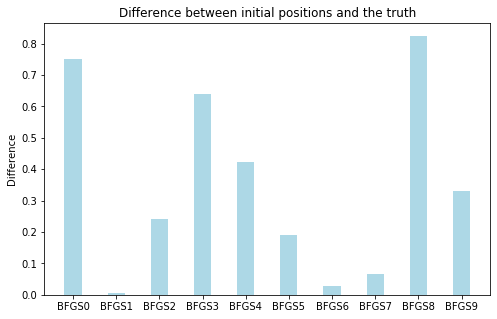

In [374]:
plot_resid2_gal(NM_list)
# plot_resid2(NM_list)
plot_resid2_gal(Po_list)
# plot_resid2(Po_list)
plot_resid2_gal(CG_list)
# plot_resid2(CG_list)
plot_resid2_gal(BFGS_list)
# plot_resid2(BFGS_list)

In [288]:
BFGS_T = [63,58,58,59,60,61,64,58,57,69]
BFGS_IT = [0,0,0,0,0,0,1,1,0,0]
P_T = [229,282,292,270,242,233,321,267,260,259]
P_IT = [10,25,21,18,11,17,24,23,25,15]
NM_T = [63,59,86,59,61,59,59,61,60,61]
NM_IT = [100,100,100,100,100,100,100,100,100,100]
CG_T = [60,58,54,56,60,62,59,61,59,60]
CG_IT = [0,0,0,0,0,0,0,0,0,0]

def get_v(t,it):
    v = []
    for t_elem,it_elem in zip(t,it):
        v.append(it_elem/t_elem)
    return v
BFGS_V = get_v(BFGS_T,BFGS_IT)
P_V = get_v(P_T,P_IT)
CG_V = get_v(CG_T,CG_IT)
NM_V = get_v(NM_T,NM_IT)


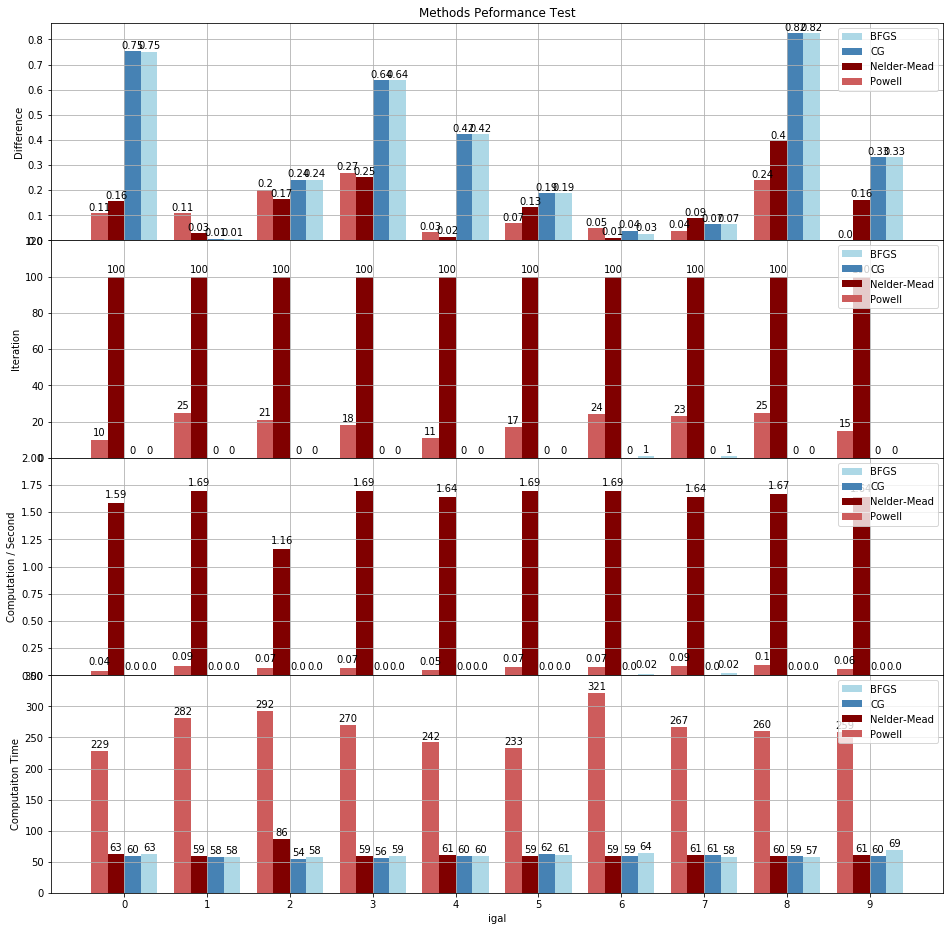

In [413]:
def plot_it(t,it,method):
    x = np.arange(len(t))
    fig,ax = plt.subplots(1,1, figsize= (8,5))
    width = 0.2
    v = []
    ax2 = ax.twinx()
    for t_elem, it_elem in zip(t,it):
        v.append(it_elem/t_elem)
    rect1 = ax.bar(x,t, width, color = 'lightblue', label = 'Computation Time')
    rect2 = ax.bar(x+width,it, width, color = 'steelblue', label = 'Iteration',zorder = 1)
    rect3 = ax2.bar(x-width,v, width, color = 'orange', zorder = 0)
    rect3 = ax.bar(x,np.zeros(len(v)), color = 'orange', label = 'Computation Speed')
    ax.set_ylabel('Computation Time\n& Iteration')
    ax2.set_ylabel('Compuation Per Second')
    plt.title(f'{method} Performance Test')
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    ax.set_xticks(np.arange(10))
    plt.show()
    
def plot_total(t,it,v,r):
    fig, axs = plt.subplots(len(t),1, figsize= (16,16), sharex = True)#comp_time,iteration,velocity,difference
    axs[0].set_title('Methods Peformance Test')
    
    def get_label(i):
        if i == 0:
            label = 'BFGS'
            color = 'lightblue'
        elif i == 1:
            label = 'CG'
            color = 'steelblue'
        elif i == 2:
            label = 'Nelder-Mead'
            color = 'maroon'
        elif i == 3:
            label = 'Powell'
            color = 'indianred'
        return label,color
    width = 0.2
    for i,method_t in enumerate(t):
        x = np.arange(len(method_t))
        label,color = get_label(i)
        axs[3].bar(x+width*(3/2-i),method_t, width, label = label, color = color)
        for x_elem, method_elem in zip(x,method_t):
            axs[3].text(x_elem+width*(3/2-i),method_elem+5,s = str(method_elem),horizontalalignment='center')
    axs[3].set_ylim(None,350)
    axs[3].set_ylabel('Computaiton Time')
    axs[3].legend(loc = 'upper right')

    for i,method_it in enumerate(it):
        x = np.arange(len(method_t))
        label,color = get_label(i)
        axs[1].bar(x+width*(3/2-i),method_it, width,label = label, color = color)
        for x_elem, method_elem in zip(x,method_it):
            axs[1].text(x_elem+width*(3/2-i),method_elem+2,s = str(method_elem),horizontalalignment='center')
    axs[1].set_ylabel('Iteration')
    axs[1].set_ylim(None,120)
    axs[1].legend()
    
    for i,method_v in enumerate(v):
        x = np.arange(len(method_v))
        label, color = get_label(i)
        axs[2].bar(x+width*(3/2-i),method_v, width,label = label, color = color)
        for x_elem, method_elem in zip(x,method_v):
            axs[2].text(x_elem+width*(3/2-i),method_elem+0.05,s = str(np.round(method_elem,2)),horizontalalignment='center')
    axs[2].set_ylim(None,2.0)

    axs[2].set_ylabel('Computation / Second')
    axs[2].legend()
    for i,method_r in enumerate(r):
        x = np.arange(len(method_r))
        label, color = get_label(i)
        diffs = []
        for k,item in enumerate(method_r):
            val = np.mean(list(item.values())[0])
            diff = np.abs(val-input_mass[k])
            diffs.append(diff)
        axs[0].bar(x+width*(3/2-i),diffs, width,label = label, color = color)
        for x_elem, diff_elem in zip(x,diffs):
            axs[0].text(x_elem+width*(3/2-i),diff_elem+0.01,s = str(np.round(diff_elem,2)),horizontalalignment='center')

        
    
    axs[0].set_ylabel('Difference')
    axs[0].legend(loc = 'upper right')
    axs[0].set_xticks(np.arange(10))
    axs[3].set_xlabel('igal')
    axs[0].legend()
    axs[0].grid()
    axs[2].grid()
    axs[1].grid()
    axs[3].grid()
    
    fig.subplots_adjust(hspace = 0)
    
    
    
T = [BFGS_T,CG_T,NM_T,P_T]
IT = [BFGS_IT,CG_IT,NM_IT,P_IT]
V = [BFGS_V,CG_V,NM_V,P_V]
RESID_list = [BFGS_list,CG_list,NM_list,Po_list]
plot_total(T,IT,V,RESID_list)
plt.savefig('Total_test.pdf', format = 'pdf')

## 